# <font color='red'>Part I. VGG16 within Encoder and Decoder</font>

## <font color='orange'>1. Dataset and DataLoader</font>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import random
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings (not recommended)

# Constants
DATA_DIR = "/kaggle/input/coco128/coco128/images/train2017"  # Path to training data
IMG_SHAPE = (256, 256)  # Target image size (Height, Width)
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  # Use GPU if available
BATCH_SIZE = 16  # Number of images processed in a batch

# Transformation pipeline for images
transform = transforms.Compose([
    transforms.Resize(IMG_SHAPE),  # Resize image to specified dimensions
    transforms.ToTensor(),  # Convert image to PyTorch tensor (C, H, W) and normalize to [0, 1]
])

class ImageDataset(Dataset):  # Custom dataset class for loading images
    def __init__(self, img_dir, transform=None, num_images=1000):
        self.img_dir = img_dir  # Directory containing images
        self.transform = transform  # Transformation pipeline (optional)
        self.img_files = os.listdir(img_dir)  # List of image filenames
        random.shuffle(self.img_files)  # Shuffle filenames for random order
        self.img_files = self.img_files[:num_images]  # Limit to a specific number of images (optional)

    def __len__(self):
        return len(self.img_files)  # Return the number of images in the dataset

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])  # Create full path to image
        img = Image.open(img_path).convert('RGB')  # Open image and ensure it's RGB (3 channels)

        if self.transform:  # Apply data transformation if provided
            img = self.transform(img)

        return img  # Return the transformed image tensor

# Load dataset
dataset = ImageDataset(DATA_DIR, transform=transform)  # Create the dataset object
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## <font color='orange'>2. Define the GAN Model</font>

### <font color='green'>2.1. Encoder (Vgg 16)</font>

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Load pre-trained VGG16 model (features only) and move it to the chosen device (CPU or GPU)
        self.vgg16 = models.vgg16(pretrained=True).features.to(DEVICE)

        # Freeze the weights of VGG16 to prevent them from being updated during training
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Define a series of transposed convolution layers for upsampling
        self.conv_transpose1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_transpose4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_transpose5 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)

        # Final convolution layer to reduce the number of channels back to 3 (RGB)
        self.final_conv = nn.Conv2d(16 + 3, 3, kernel_size=3, padding=1)

    def forward(self, secret, cover):
        # Pass the secret image through VGG16 for feature extraction
        x = self.vgg16(secret)  # Encoded secret image, shape: (batch_size, 512, 8, 8)

        # Upsample the encoded secret features to match the cover image dimensions
        x = self.conv_transpose1(x)  # (batch_size, 256, 16, 16)
        x = self.conv_transpose2(x)  # (batch_size, 128, 32, 32)
        x = self.conv_transpose3(x)  # (batch_size, 64, 64, 64)
        x = self.conv_transpose4(x)  # (batch_size, 32, 128, 128)
        x = self.conv_transpose5(x)  # (batch_size, 16, 256, 256)

        # Add a small amount of Gaussian noise to the cover image
        cover_noise = cover + torch.randn_like(cover) * 0.01

        # Concatenate the upsampled secret features and the cover image with added noise
        x = torch.cat([cover_noise, x], dim=1)  # Shape: (batch_size, 16 + 3, 256, 256)

        # Final convolution to produce the encoded image (C_prime)
        output_Cprime = torch.sigmoid(self.final_conv(x))  # Shape: (batch_size, 3, 256, 256)

        return output_Cprime

### <font color='green'>2.2. Decoder</font>

In [3]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Define a series of convolutional layers for decoding
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Input channel: 3 (RGB), Output channels: 64, Kernel size: 3x3, Padding: 1
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  # Input channels: 64, Output channels: 32, Kernel size: 3x3, Padding: 1
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)  # Input channels: 32, Output channels: 16, Kernel size: 3x3, Padding: 1
        self.final_conv = nn.Conv2d(16, 3, kernel_size=3, padding=1)  # Input channels: 16, Output channels: 3 (RGB), Kernel size: 3x3, Padding: 1

    def forward(self, encoded_img):
        # Apply ReLU activation to each convolutional layer
        x = F.relu(self.conv1(encoded_img))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Apply sigmoid activation to the final layer to normalize output to [0, 1]
        output_Sprime = torch.sigmoid(self.final_conv(x))
        return output_Sprime

### <font color='green'>2.3. Split Images</font> 
> Split images into `Secret` and `Cover`

In [4]:
# Split dataset into secret and cover images
def get_secret_and_cover_images(data_loader):
    for images in data_loader:
        half_size = images.shape[0] // 2
        input_S = images[:half_size].to(DEVICE)  # Secret images
        input_C = images[half_size:].to(DEVICE)  # Cover images
        yield input_S, input_C

# Initialize models, optimizers, and loss functions
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]  


### <font color='green'>2.4. Loss Functions</font> 

In [5]:
def rev_loss(s_true, s_pred, beta=1.0):
    """
    Reconstruction loss function (mean squared error)
    """
    return beta * torch.sum((s_true - s_pred) ** 2)  # Beta weights the importance of this loss

# Example of adjusting the learning rate schedule
def lr_schedule(epoch):
    """
    Learning rate scheduler based on epochs
    """
    if epoch < 100:
        return 0.001
    elif epoch < 300:
        return 0.0005
    else:
        return 0.0001

# Using a different loss function (Perceptual Loss)
def perceptual_loss(input, target):
    """
    Perceptual loss based on VGG16 features
    """
    vgg = models.vgg16(pretrained=True).features.to(DEVICE).eval()
    with torch.no_grad():
        input_features = vgg(input)
        target_features = vgg(target)
    return F.mse_loss(input_features, target_features)  # Mean squared error between feature maps

# Modify the full_loss function to incorporate perceptual loss
def full_loss(y_true, y_pred):
    """
    Combined loss function with reconstruction and perceptual loss
    """
    s_true, c_true = y_true[:, :3], y_true[:, 3:]  # Split real images into secret and cover parts
    s_pred, c_pred = y_pred[:, :3], y_pred[:, 3:]  # Split prediction into secret and cover parts
    s_loss = rev_loss(s_true, s_pred)  # Reconstruction loss for the secret image
    c_loss = perceptual_loss(c_pred, c_true)  # Perceptual loss for the cover image
    return s_loss + c_loss  # Combine both losses

## <font color='orange'>3. Training Loop</font>

In [4]:
NUM_EPOCHS = 300  # Number of training epochs

# Training loop
for epoch in range(NUM_EPOCHS):
    # Set both encoder and decoder to training mode
    encoder.train()
    decoder.train()

    total_loss = 0
    for input_S, input_C in tqdm(get_secret_and_cover_images(data_loader), total=len(data_loader)):
        # Clear gradients accumulated from previous iterations
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Forward pass:
        # 1. Encode the secret image and cover image together
        encoded_Cprime = encoder(input_S, input_C)

        # 2. Decode the encoded image (C_prime) to reconstruct the secret image (S_prime)
        decoded_Sprime = decoder(encoded_Cprime)

        # Combine images for loss calculation:
        # - y_true: Concatenates the original secret and cover images
        # - y_pred: Concatenates the reconstructed secret and encoded cover image
        y_true = torch.cat([input_S, input_C], dim=1)
        y_pred = torch.cat([decoded_Sprime, encoded_Cprime], dim=1)

        # Calculate the combined loss (reconstruction & perceptual)
        loss = full_loss(y_true, y_pred)
        total_loss += loss.item()

        # Backward pass and optimization:
        # 1. Propagate the loss backwards to calculate gradients
        loss.backward()

        # 2. Update the weights of the encoder and decoder based on the gradients
        encoder_optimizer.step()
        decoder_optimizer.step()

    # Learning rate scheduling:
    # Update the learning rates for both optimizers based on the current epoch
    for param_group in encoder_optimizer.param_groups:
        param_group['lr'] = lr_schedule(epoch)
    for param_group in decoder_optimizer.param_groups:
        param_group['lr'] = lr_schedule(epoch)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

    # Clear unused memory on the GPU (if applicable)
    torch.cuda.empty_cache()

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


Epoch [10/300], Loss: 79050.3291


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch [20/300], Loss: 63150.8779


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [30/300], Loss: 54211.7397


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch [40/300], Loss: 47823.7773


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [50/300], Loss: 43647.5894


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [60/300], Loss: 38819.1655


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [70/300], Loss: 37299.3457


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [80/300], Loss: 32982.8755


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch [90/300], Loss: 30819.6240


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch [100/300], Loss: 31153.7666


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Epoch [110/300], Loss: 27280.7620


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [120/300], Loss: 25891.1426


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Epoch [130/300], Loss: 23967.9141


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch [140/300], Loss: 23210.8651


100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


Epoch [150/300], Loss: 25083.3643


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch [160/300], Loss: 24026.7371


100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


Epoch [170/300], Loss: 22721.2272


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch [180/300], Loss: 21152.4680


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [190/300], Loss: 21403.0945


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [200/300], Loss: 20088.6667


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [210/300], Loss: 19497.0233


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [220/300], Loss: 17227.5784


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Epoch [230/300], Loss: 21552.1838


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch [240/300], Loss: 18427.1346


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch [250/300], Loss: 17159.9642


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Epoch [260/300], Loss: 16951.9630


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch [270/300], Loss: 15499.2524


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Epoch [280/300], Loss: 16381.5212


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch [290/300], Loss: 15830.3606


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]

Epoch [300/300], Loss: 16098.0566


## <font color='orange'>4. Saving Models</font>

In [6]:
# Save the encoder and decoder models
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

print("Encoder and Decoder models have been saved successfully.")

Encoder and Decoder models have been saved successfully.


In [7]:
# Load the encoder and decoder models
encoder = Encoder()  # Ensure that the Encoder model is defined as per your architecture
decoder = Decoder()  # Ensure that the Decoder model is defined as per your architecture

# Load the saved state dicts
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

# Set models to evaluation mode if performing inference
encoder.eval()
decoder.eval()

print("Encoder and Decoder models have been loaded successfully.")

Encoder and Decoder models have been loaded successfully.


## <font color='orange'>5. Evaluate Model</font>

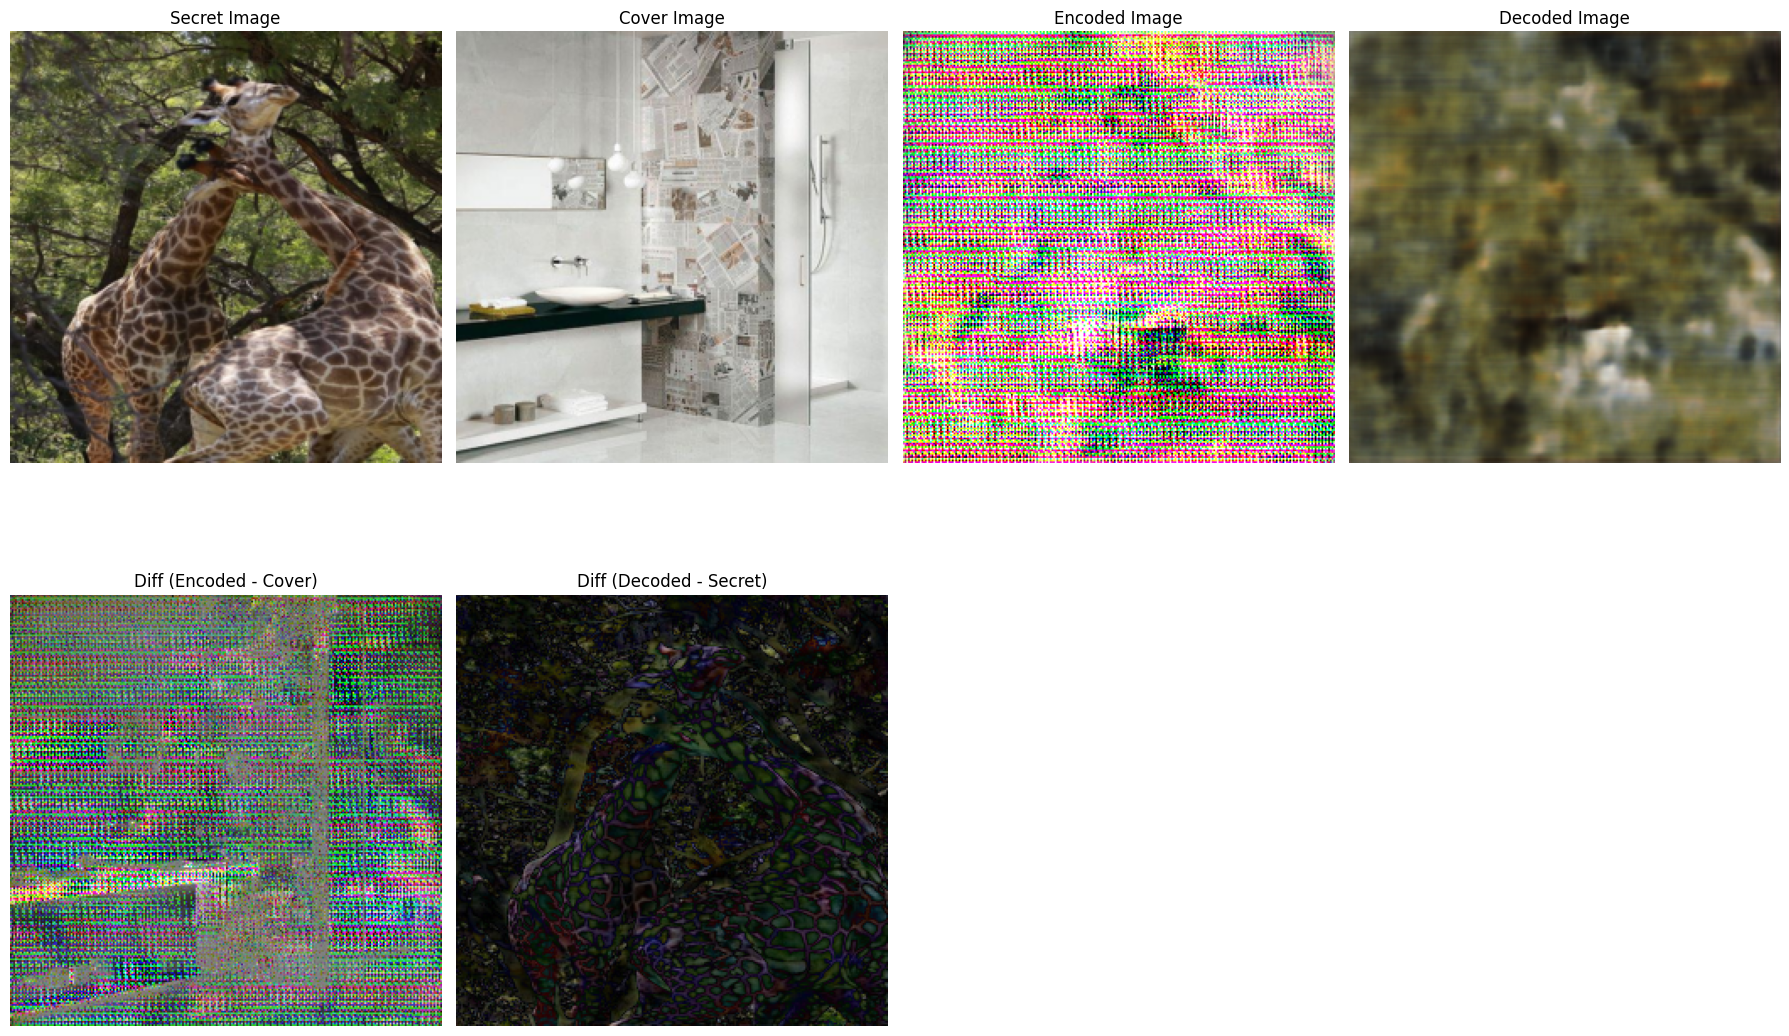

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to show image comparison
def show_image_comparison(secret_img, cover_img, encoded_img, decoded_img):
    # Ensure all images are on the CPU and detach from the computation graph before converting to numpy
    secret_img_np = secret_img.permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, C)
    cover_img_np = cover_img.permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, C)
    encoded_img_np = encoded_img.permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, C)

    # Resize the decoded image to match the secret image's dimensions
    decoded_img_resized = F.interpolate(decoded_img.unsqueeze(0), size=secret_img_np.shape[:2], mode='bicubic', align_corners=False).squeeze(0)
    decoded_img_np = decoded_img_resized.permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, C)

    # Calculate the difference between images
    diff_encoded = np.abs(encoded_img_np - cover_img_np)  # Shape: (H, W, C)
    diff_decoded = np.abs(decoded_img_np - secret_img_np)  # Shape: (H, W, C)

    # Plotting the images
    plt.figure(figsize=(18, 12))

    # Secret image
    plt.subplot(2, 4, 1)
    plt.imshow(secret_img_np)
    plt.title('Secret Image')
    plt.axis('off')

    # Cover image
    plt.subplot(2, 4, 2)
    plt.imshow(cover_img_np)
    plt.title('Cover Image')
    plt.axis('off')

    # Encoded image (Cover + Secret)
    plt.subplot(2, 4, 3)
    plt.imshow(encoded_img_np)
    plt.title('Encoded Image')
    plt.axis('off')

    # Decoded image (Recovered Secret)
    plt.subplot(2, 4, 4)
    plt.imshow(decoded_img_np)
    plt.title('Decoded Image')
    plt.axis('off')

    # Difference between Encoded and Cover Image
    plt.subplot(2, 4, 5)
    plt.imshow(diff_encoded)
    plt.title('Diff (Encoded - Cover)')
    plt.axis('off')

    # Difference between Decoded and Secret Image
    plt.subplot(2, 4, 6)
    plt.imshow(diff_decoded)
    plt.title('Diff (Decoded - Secret)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ------------------------------------- Visualization ---------------------------------------------
# Generate images after training
encoder.to(DEVICE)
decoder.to(DEVICE)

# Set the models to evaluation mode
encoder.eval()
decoder.eval()

# Inference and visualization
with torch.no_grad():
    for input_S, input_C in get_secret_and_cover_images(data_loader):
        # Move inputs to the same device as the models
        input_S, input_C = input_S.to(DEVICE), input_C.to(DEVICE)

        # Forward pass through the encoder and decoder
        encoded_Cprime = encoder(input_S, input_C)
        decoded_Sprime = decoder(encoded_Cprime)

        # Show comparison for the first image in the batch
        show_image_comparison(input_S[0], input_C[0], encoded_Cprime[0], decoded_Sprime[0])
        break  # Visualize only the first batch


# <font color='red'> Part II Using (Encoder and Decoder) only</font>

## <font color='orange'>1. Imports and Constants</font>

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image

# Constants
DATA_DIR = "/kaggle/input/coco128/coco128/images/train2017"
IMG_SHAPE = (256, 256, 3)
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <font color='orange'>2. Loading and Preprocessing Dataset</font>

In [7]:
class ImageDataset(Dataset):
    """
    Custom Image Dataset for Secret Sharing Task
    """
    def __init__(self, img_dir, transform=None, num_images=1000):
        self.img_dir = img_dir  # Directory containing images
        self.transform = transform  # Optional transformation pipeline
        self.img_files = os.listdir(img_dir)  # List of image filenames
        random.shuffle(self.img_files)  # Shuffle filenames for randomness
        self.img_files = self.img_files[:num_images]  # Limit images (optional)

    def __len__(self):
        return len(self.img_files)  # Return total number of images

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])  # Full path to image
        img = Image.open(img_path).convert("RGB")  # Open and convert to RGB
        if self.transform:
            img = self.transform(img)  # Apply transformation if provided
        return img  # Return preprocessed image

# Image transformations (adjust IMG_SHAPE as needed)
transform = transforms.Compose([
    transforms.Resize((IMG_SHAPE[0], IMG_SHAPE[1])),  # Resize to specified size
    transforms.ToTensor(),  # Convert to PyTorch tensor and normalize
])

# Load dataset
dataset = ImageDataset(DATA_DIR, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## <font color='orange'>3. Normalize and Split Dataset</font>

In [8]:
def split_dataset(X_data):
    X_data = X_data / 255.0  # Normalize
    input_S = X_data[:X_data.shape[0] // 2]
    input_C = X_data[X_data.shape[0] // 2:]
    return input_S, input_C

## <font color='orange'>4. Show Random Images</font>

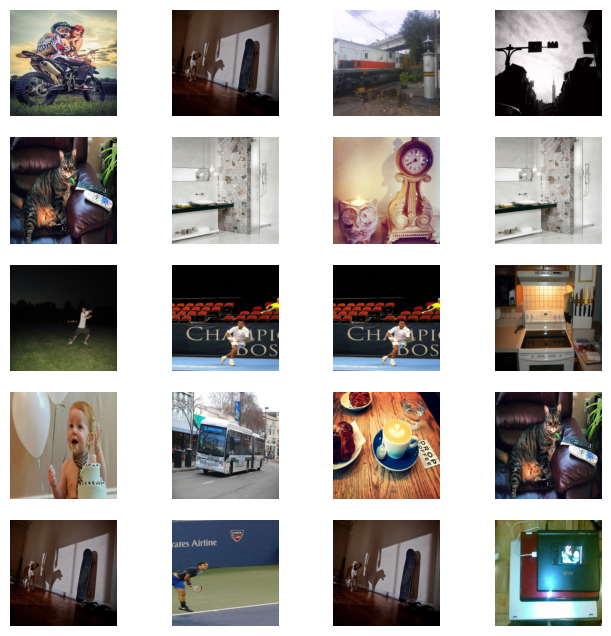

In [9]:
def show_images(imgs, rows=5, cols=4):
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, rows * cols + 1):
        img_idx = random.choice(range(imgs.shape[0]))
        img = imgs[img_idx].permute(1, 2, 0).cpu().numpy()  # Convert from Tensor to numpy for visualization
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Example usage after loading data
data_iter = iter(data_loader)
X_data = next(data_iter)
show_images(X_data)

## <font color='orange'>5. Loss Functions</font>

In [10]:
beta = 1.0  # Hyperparameter to balance reconstruction loss

def rev_loss(s_true, s_pred, beta=1.0):
    """
    Reconstruction loss for the secret image (mean squared error)
    """
    return beta * torch.sum((s_true - s_pred) ** 2)  # Calculate the squared difference and sum

def full_loss(y_true, y_pred):
    """
    Combined loss function for the secret and cover images
    """
    s_true, c_true = y_true[:, :3], y_true[:, 3:]  # Split true images into secret and cover parts
    s_pred, c_pred = y_pred[:, :3], y_pred[:, 3:]  # Split predicted images into secret and cover parts

    s_loss = rev_loss(s_true, s_pred)  # Calculate reconstruction loss for the secret image
    c_loss = torch.sum((c_true - c_pred) ** 2)  # Calculate reconstruction loss for the cover image

    return s_loss + c_loss  # Combine the losses for the secret and cover images

## <font color='orange'>6. Encoder and Decoder Models</font>

### <font color='green'>6.1. Encoder model</font>

In [17]:
class Encoder(nn.Module):
    """
    Encoder Network for Secret Sharing Task
    """
    def __init__(self):
        super(Encoder, self).__init__()

        # Convolutions for processing the secret image (S)
        self.conv3_1 = nn.Conv2d(3, 50, kernel_size=3, stride=1, padding=1)  # Input: 3 channels, Output: 50 channels
        self.conv4_1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)  # Input: 3 channels, Output: 10 channels
        self.conv5_1 = nn.Conv2d(3, 5, kernel_size=5, stride=1, padding=2)  # Input: 3 channels, Output: 5 channels

        # Second set of convolutions for combined features
        self.conv3_2 = nn.Conv2d(65, 50, kernel_size=3, stride=1, padding=1)  # Input: 65 channels, Output: 50 channels
        self.conv4_2 = nn.Conv2d(65, 10, kernel_size=3, stride=1, padding=1)  # Input: 65 channels, Output: 10 channels
        self.conv5_2 = nn.Conv2d(65, 5, kernel_size=5, stride=1, padding=2)  # Input: 65 channels, Output: 5 channels

        # Final convolution to produce the encoded cover image (C') with 3 channels
        self.final_conv = nn.Conv2d(68, 3, kernel_size=3, stride=1, padding=1)  # Input: 68 channels, Output: 3 channels

    def forward(self, input_S, input_C):
        """
        Forward pass of the encoder network
        """
        # First set of convolutions for the secret image
        x3_1 = F.relu(self.conv3_1(input_S))
        x4_1 = F.relu(self.conv4_1(input_S))
        x5_1 = F.relu(self.conv5_1(input_S))

        # Concatenate the outputs from the first set of convolutions
        x = torch.cat([x3_1, x4_1, x5_1], dim=1)  # Combine feature maps from different convolutions

        # Second set of convolutions on the combined features
        x3_2 = F.relu(self.conv3_2(x))
        x4_2 = F.relu(self.conv4_2(x))
        x5_2 = F.relu(self.conv5_2(x))

        # Concatenate the outputs from the second set of convolutions
        x = torch.cat([x3_2, x4_2, x5_2], dim=1)  # Combine feature maps again

        # Concatenate the processed secret image features with the cover image
        x = torch.cat([x, input_C], dim=1)  # Ensure correct channel order for concatenation

        # Final convolution to produce the encoded cover image (C')
        output_Cprime = self.final_conv(x)  # Output shape: (batch_size, 3, 256, 256) assuming input is 256x256

        return output_Cprime

In [19]:
# from torchviz import make_dot

# # Create an instance of the model
# model = Encoder()

# # Create dummy input for testing the architecture visualization
# dummy_input_S = torch.randn(1, 3, 256, 256)  # Example input for the secret image
# dummy_input_C = torch.randn(1, 3, 256, 256)  # Example input for the cover image

# # Generate the graph of the model
# output = model(dummy_input_S, dummy_input_C)
# graph = make_dot(output, params=dict(model.named_parameters()))

# # Save the graph as an image
# graph.render("encoder_architecture_Part II", format="png")

'encoder_architecture_Part II.png'

### <font color='green'>6.2. Decoder model</font>

In [13]:
class GaussianNoise(nn.Module):
    """
    Custom Module to Add Gaussian Noise During Training
    """
    def __init__(self, std=0.01):
        super(GaussianNoise, self).__init__()
        self.std = std  # Standard deviation of the noise

    def forward(self, x):
        """
        Apply Gaussian noise only during training phase
        """
        if self.training:  # Check if currently in training mode
            noise = torch.randn_like(x) * self.std  # Sample noise with the same shape as input
            return x + noise  # Add noise to the input
        return x  # No noise added during evaluation

class Decoder(nn.Module):
    """
    Decoder Network for Secret Sharing Task
    """
    def __init__(self):
        super(Decoder, self).__init__()

        self.noise_layer = GaussianNoise(0.01)  # Custom layer for adding noise

        # Convolutions for processing the encoded cover image (C')
        self.conv3_1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)  # Input: 3 channels, Output: 50 channels
        self.conv4_1 = nn.Conv2d(3, 10, kernel_size=3, padding=1)  # Input: 3 channels, Output: 10 channels
        self.conv5_1 = nn.Conv2d(3, 5, kernel_size=5, padding=2)  # Input: 3 channels, Output: 5 channels

        # Final convolution to produce the reconstructed secret image (S')
        self.final_conv = nn.Conv2d(65, 3, kernel_size=3, padding=1)  # Input: 65 channels, Output: 3 channels

    def forward(self, reveal_input):
        """
        Forward pass of the decoder network
        """
        reveal_input = self.noise_layer(reveal_input)  # Add Gaussian noise (training only)
        x3_1 = F.relu(self.conv3_1(reveal_input))
        x4_1 = F.relu(self.conv4_1(reveal_input))
        x5_1 = F.relu(self.conv5_1(reveal_input))

        x = torch.cat([x3_1, x4_1, x5_1], dim=1)  # Concatenate feature maps

        output_Sprime = self.final_conv(x)  # Output shape: (batch_size, 3, 256, 256) assuming input is 256x256

        return output_Sprime

In [20]:
# # Create an instance of the model
# model_decoder = Decoder()

# # Create dummy input for testing the architecture visualization
# dummy_input = torch.randn(1, 3, 256, 256)  # Example input (encoded cover image)

# # Generate the graph of the model
# output = model_decoder(dummy_input)
# graph = make_dot(output, params=dict(model_decoder.named_parameters()))

# # Save the graph as an image
# graph.render("decoder_architecture_Part II", format="png")

'decoder_architecture_Part II.png'

## <font color='orange'>7. Creating the Full Autoencoder Model</font>

In [22]:
class Autoencoder(nn.Module):
    """
    Autoencoder Model for Secret Sharing Task
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()  # Instance of the encoder network
        self.decoder = Decoder()  # Instance of the decoder network

    def forward(self, input_S, input_C):
        """
        Forward pass of the autoencoder
        """
        output_Cprime = self.encoder(input_S, input_C)  # Encode secret and cover images
        output_Sprime = self.decoder(output_Cprime)  # Decode the encoded cover image
        return torch.cat([output_Sprime, output_Cprime], dim=1)  # Combine reconstructed secret and encoded cover

# Instantiate the model (replace 'DEVICE' with your target device)
autoencoder_model = Autoencoder().to(DEVICE)

## <font color='orange'>8. Training Loop and Learning Rate Schedule</font>

In [15]:
def lr_schedule(epoch):
    """
    Learning rate scheduler based on epochs
    """
    if epoch < 200:
        return 0.001
    elif epoch < 400:
        return 0.0003
    elif epoch < 600:
        return 0.0001
    else:
        return 0.00003

# Learning rate scheduler
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)  # Create Adam optimizer with initial learning rate of 0.001
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)  # Create a LambdaLR scheduler using the defined `lr_schedule` function

In [104]:
NB_EPOCHS = 500  # Number of training epochs
BATCH_SIZE = 32  # Batch size for training
loss_history = []  # List to store average loss per epoch

for epoch in range(NB_EPOCHS):
    # Set model to training mode
    autoencoder_model.train()

    total_ae_loss = []  # List to store losses for each batch in the epoch

    for batch in tqdm(data_loader):
        # Separate secret and cover images from the batch
        batch_size = batch.size(0) // 2  # Assuming half batch for secret and half for cover
        input_S = batch[:batch_size].to(DEVICE)  # Secret image batch (move to device)
        input_C = batch[batch_size:].to(DEVICE)  # Cover image batch (move to device)

        # Forward pass (prediction)
        output = autoencoder_model(input_S, input_C)
        output_Sprime = output[:, :3, :, :]  # Reconstructed secret image
        output_Cprime = output[:, 3:, :, :]  # Encoded cover image

        # Calculate total loss (combined secret and cover reconstruction)
        loss = full_loss(torch.cat([input_S, input_C], dim=1), output)
        total_ae_loss.append(loss.item())  # Append loss value

        # Backward pass (update model parameters)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_ae_loss = np.mean(total_ae_loss)
    loss_history.append(avg_ae_loss)  # Store average loss for this epoch

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{NB_EPOCHS}, AE loss: {avg_ae_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch 10/500, AE loss: 1915933.59375


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch 20/500, AE loss: 1902322.84375


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch 30/500, AE loss: 1880522.71875


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch 40/500, AE loss: 1864692.40625


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Epoch 50/500, AE loss: 1853142.90625


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 60/500, AE loss: 1834315.1875


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch 70/500, AE loss: 1814700.78125


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epoch 80/500, AE loss: 1795166.625


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch 90/500, AE loss: 1770925.78125


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch 100/500, AE loss: 1755370.46875


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch 110/500, AE loss: 1732387.21875


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch 120/500, AE loss: 1712323.03125


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epoch 130/500, AE loss: 1691387.84375


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Epoch 140/500, AE loss: 1669104.09375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 150/500, AE loss: 1646519.5


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 160/500, AE loss: 1624205.0625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 170/500, AE loss: 1589779.15625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 180/500, AE loss: 1572440.59375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 190/500, AE loss: 1542113.875


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 200/500, AE loss: 1513461.71875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 210/500, AE loss: 1480106.6875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 220/500, AE loss: 1441291.9375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 230/500, AE loss: 1415689.5


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 240/500, AE loss: 1381252.84375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 250/500, AE loss: 1356555.53125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 260/500, AE loss: 1319169.5625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 270/500, AE loss: 1292821.625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 280/500, AE loss: 1247226.15625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 290/500, AE loss: 1223937.28125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 300/500, AE loss: 1185111.90625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 310/500, AE loss: 1166513.25


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 320/500, AE loss: 1110520.0


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 330/500, AE loss: 1091472.09375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 340/500, AE loss: 1068308.21875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 350/500, AE loss: 1043585.71875


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 360/500, AE loss: 1020656.875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 370/500, AE loss: 974053.265625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 380/500, AE loss: 945896.25


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 390/500, AE loss: 918719.75


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 400/500, AE loss: 867869.296875


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 410/500, AE loss: 871944.375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 420/500, AE loss: 846019.0625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 430/500, AE loss: 821016.34375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 440/500, AE loss: 789298.890625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 450/500, AE loss: 759193.578125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 460/500, AE loss: 765908.390625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 470/500, AE loss: 727830.609375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 480/500, AE loss: 715567.5


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 490/500, AE loss: 679978.28125


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

Epoch 500/500, AE loss: 679279.0625


## <font color='orange'>9. Saving Models</font>

In [114]:
encoder_path = "encoder_model.pth"
decoder_path = "decoder_model.pth"
autoencoder_path = "autoencoder_model.pth"

torch.save(autoencoder_model.state_dict(), autoencoder_path)
torch.save(autoencoder_model.encoder.state_dict(), encoder_path)
torch.save(autoencoder_model.decoder.state_dict(), decoder_path)

## <font color='orange'>10. Evaluate Model</font>

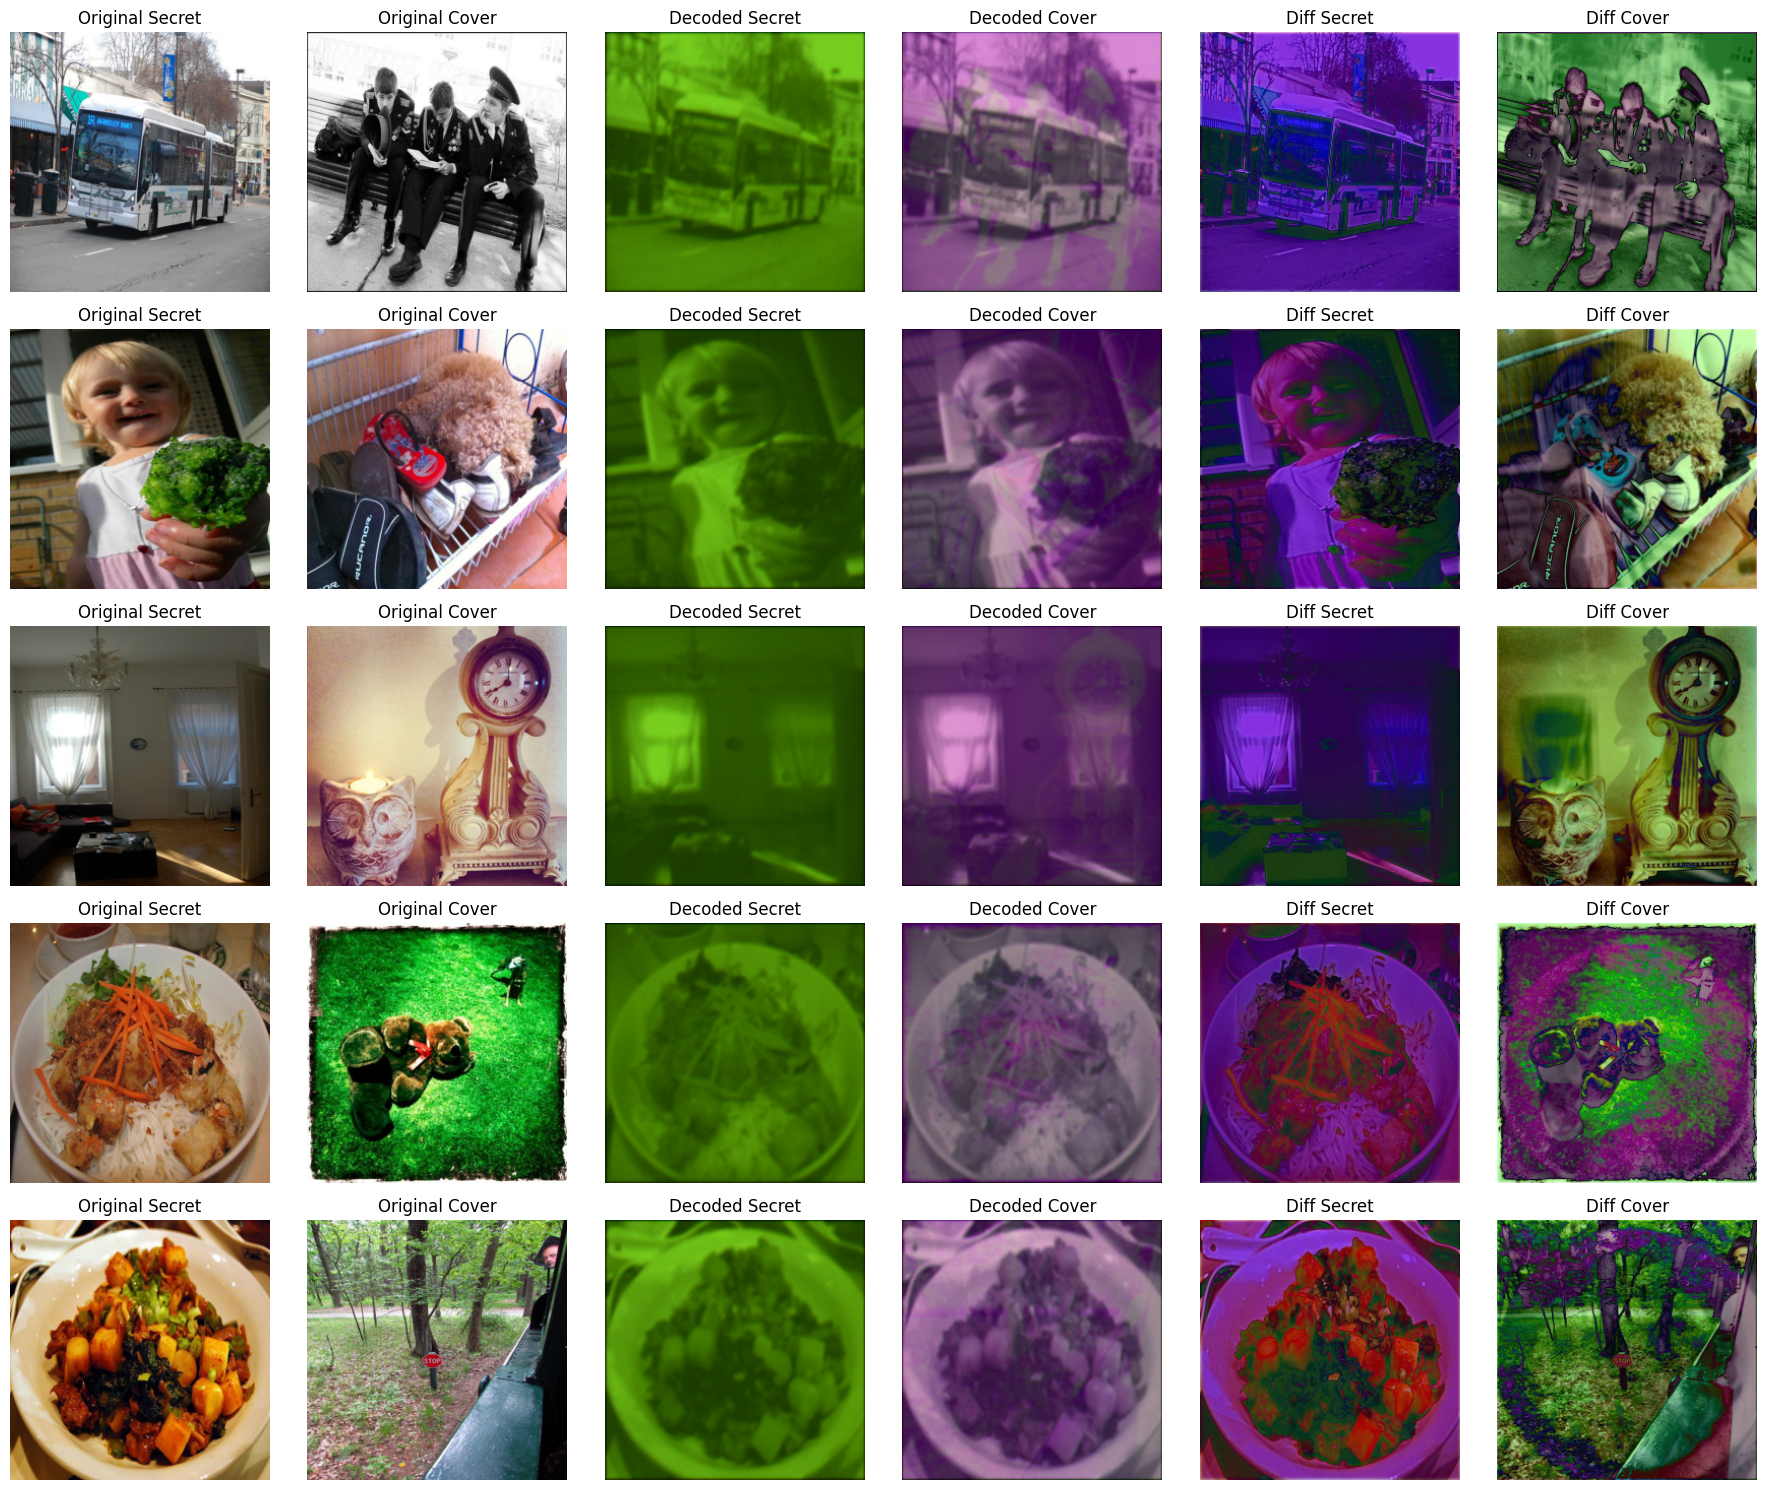

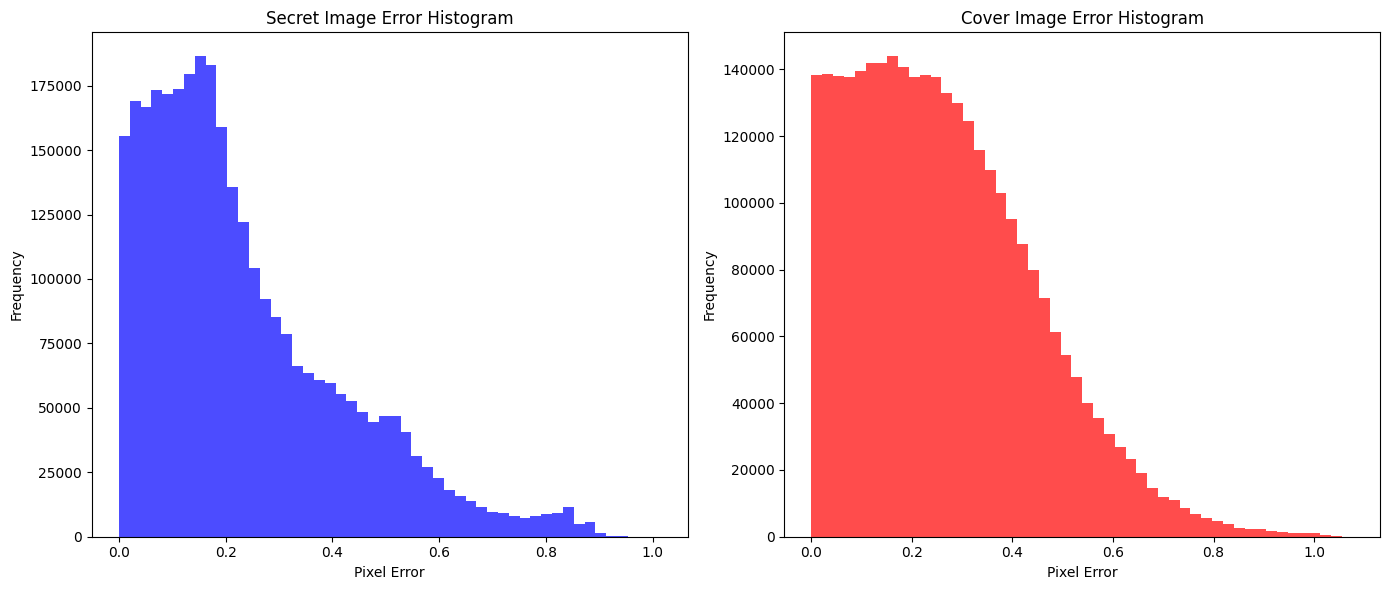

In [110]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Functions as provided
def preprocess_images(images, target_shape):
    target_size = target_shape[:2]  # Only height and width
    transform = transforms.Resize(target_size)
    resized_images = torch.zeros((len(images), images.shape[1], *target_size)).to(DEVICE)
    
    for i in range(len(images)):
        resized_images[i] = transform(images[i])  # Apply transform on each image
    return resized_images

def pixel_errors(original_S, original_C, decoded_S, decoded_C):
    diff_S = torch.abs(original_S - decoded_S)
    diff_C = torch.abs(original_C - decoded_C)
    return diff_S, diff_C

def show_diff_images(original_S, original_C, decoded_S, decoded_C, diff_S, diff_C, num_images=5):
    fig, axs = plt.subplots(num_images, 6, figsize=(18, 3 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(original_S[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[i, 0].set_title("Original Secret")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(original_C[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[i, 1].set_title("Original Cover")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(decoded_S[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[i, 2].set_title("Decoded Secret")
        axs[i, 2].axis('off')
        
        axs[i, 3].imshow(decoded_C[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[i, 3].set_title("Decoded Cover")
        axs[i, 3].axis('off')
        
        axs[i, 4].imshow(diff_S[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='hot')
        axs[i, 4].set_title("Diff Secret")
        axs[i, 4].axis('off')
        
        axs[i, 5].imshow(diff_C[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='hot')
        axs[i, 5].set_title("Diff Cover")
        axs[i, 5].axis('off')
    
    plt.tight_layout()
    plt.show()

def pixel_histogram(diff_S, diff_C):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(diff_S.detach().cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Secret Image Error Histogram')
    plt.xlabel('Pixel Error')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(diff_C.detach().cpu().numpy().flatten(), bins=50, color='red', alpha=0.7)
    plt.title('Cover Image Error Histogram')
    plt.xlabel('Pixel Error')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    
# ------------------------------------- Visualization --------------------------------------------

# Load a batch from the data loader and pass through the autoencoder
for batch in data_loader:
    # Split the batch into secret and cover images
    batch_size = batch.size(0) // 2
    input_S = batch[:batch_size].to(DEVICE)  # Secret images
    input_C = batch[batch_size:].to(DEVICE)  # Cover images

    # Forward pass through the model to get decoded images
    output = autoencoder_model(input_S, input_C)
    decoded_S = output[:, :3, :, :]  # Decoded secret images
    decoded_C = output[:, 3:, :, :]  # Encoded cover images

    # Preprocess images if necessary
    target_shape = (256, 256, 3)  # Height, Width, Channels
    preprocessed_S = preprocess_images(input_S, target_shape)
    preprocessed_C = preprocess_images(input_C, target_shape)
    preprocessed_decoded_S = preprocess_images(decoded_S, target_shape)
    preprocessed_decoded_C = preprocess_images(decoded_C, target_shape)

    # Calculate pixel errors
    diff_S, diff_C = pixel_errors(preprocessed_S, preprocessed_C, preprocessed_decoded_S, preprocessed_decoded_C)

    # Display images and differences
    show_diff_images(preprocessed_S, preprocessed_C, preprocessed_decoded_S, preprocessed_decoded_C, diff_S, diff_C, num_images=5)

    # Display pixel error histograms
    pixel_histogram(diff_S, diff_C)
    
    break  # Stop after processing the first batch

## <font color='orange'>11. Rerun models again for more training loops</font>

In [ ]:
import torch

# Paths to saved models
encoder_path = "encoder_model.pth"
decoder_path = "decoder_model.pth"
autoencoder_path = "autoencoder_model.pth"

# Initialize the models (same architecture as used before)
autoencoder_model = Autoencoder().to(DEVICE)

# Load the saved state dictionaries
autoencoder_model.load_state_dict(torch.load(autoencoder_path))
autoencoder_model.encoder.load_state_dict(torch.load(encoder_path))
autoencoder_model.decoder.load_state_dict(torch.load(decoder_path))

# You can now reinitialize the optimizer
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

# Continue training as before
NB_EPOCHS = 500  # New number of epochs for continued training
loss_history = []

for epoch in range(NB_EPOCHS):
    autoencoder_model.train()
    total_ae_loss = []

    for batch in tqdm(data_loader):
        batch_size = batch.size(0) // 2
        input_S = batch[:batch_size].to(DEVICE)
        input_C = batch[batch_size:].to(DEVICE)

        # Forward pass
        output = autoencoder_model(input_S, input_C)
        output_Sprime = output[:, :3, :, :]  # Decoded secret
        output_Cprime = output[:, 3:, :, :]  # Encoded cover

        # Compute losses
        loss = full_loss(torch.cat([input_S, input_C], dim=1), output)
        total_ae_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_ae_loss = np.mean(total_ae_loss)
    loss_history.append(avg_ae_loss)

    # Print loss every 10 epochs and optionally save models again
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{NB_EPOCHS}, AE loss: {avg_ae_loss}")
print("Continued training completed.")


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch 10/500, AE loss: 238759.8671875


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch 20/500, AE loss: 94704.1953125


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch 30/500, AE loss: 63283.337890625


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Epoch 40/500, AE loss: 53382.1513671875


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 50/500, AE loss: 46504.171875


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 60/500, AE loss: 45420.455078125


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 70/500, AE loss: 40412.8349609375


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 80/500, AE loss: 38033.37109375


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch 90/500, AE loss: 38050.41015625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 100/500, AE loss: 37259.1640625


100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Epoch 110/500, AE loss: 37598.1494140625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 120/500, AE loss: 36274.00390625


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epoch 130/500, AE loss: 33414.34521484375


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch 140/500, AE loss: 34630.04150390625


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch 150/500, AE loss: 46048.119140625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 160/500, AE loss: 35484.830078125


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 170/500, AE loss: 34155.3076171875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 180/500, AE loss: 32285.85107421875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 190/500, AE loss: 34210.48876953125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 200/500, AE loss: 33879.51611328125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 210/500, AE loss: 33031.26025390625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 220/500, AE loss: 32790.7431640625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 230/500, AE loss: 31457.9443359375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 240/500, AE loss: 32561.48046875


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 250/500, AE loss: 33742.25634765625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 260/500, AE loss: 35983.82568359375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 270/500, AE loss: 33728.134765625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 280/500, AE loss: 31444.408203125


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 290/500, AE loss: 33536.103515625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 300/500, AE loss: 31461.01708984375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 310/500, AE loss: 31379.03125


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 320/500, AE loss: 31572.7646484375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 330/500, AE loss: 31765.49462890625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 340/500, AE loss: 32371.2890625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 350/500, AE loss: 31063.73193359375


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 360/500, AE loss: 33544.9462890625


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 370/500, AE loss: 29645.13330078125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 380/500, AE loss: 31329.001953125


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 390/500, AE loss: 34546.26318359375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 400/500, AE loss: 32567.14697265625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 410/500, AE loss: 32156.09521484375


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Epoch 420/500, AE loss: 31175.47412109375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 430/500, AE loss: 30877.32763671875


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 440/500, AE loss: 31843.103515625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 450/500, AE loss: 31755.76904296875


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 460/500, AE loss: 31612.52734375


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 470/500, AE loss: 31661.931640625


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 480/500, AE loss: 31416.71142578125


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch 490/500, AE loss: 31530.5302734375


 25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

In [ ]:
encoder_path = "encoder_model.pth"
decoder_path = "decoder_model.pth"
autoencoder_path = "autoencoder_model.pth"

torch.save(autoencoder_model.state_dict(), autoencoder_path)
torch.save(autoencoder_model.encoder.state_dict(), encoder_path)
torch.save(autoencoder_model.decoder.state_dict(), decoder_path)